<div style="
    background: linear-gradient(135deg, #f1fdf7, #dcfce7);
    color: #14532d;
    padding: 28px 32px;
    border-radius: 14px;
    box-shadow: 0 8px 18px rgba(0,0,0,0.10);
">
    <h1 style="margin:0;">🤖 Classification Automatique de Produits E-commerce</h1>
    <h3 style="margin-top:8px; font-weight:normal;">
        NOTEBOOK 5 — Modélisation Deep Learning
    </h3>
    <p><b>Objectifs :</b></p>
    <ul style="margin-top:6px;">
        <li>Préparer les données pour le Deep Learning</li>
        <li>Tester plusieurs architectures (CNN, Transfer Learning)</li>
        <li>Évaluer les performances complètes</li>
        <li>Sauvegarder le meilleur modèle pour l’API</li>
    </ul>
    <p><b>Modèles testés :</b></p>
    <ul>
        <li><b>CNN Custom</b> (baseline)</li>
        <li><b>MobileNetV3-Small</b></li>
        <li><b>EfficientNetB0</b></li>
        <li><b>VGG16</b></li>
    </ul>
    <p><b>Date :</b> Février 2026</p>
</div>


### IMPORTS

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import (
    VGG16, EfficientNetB0, MobileNetV3Small
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
)

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score
)

# Utils
from tqdm import tqdm
import joblib
import json
import time

# Reproductibilité
np.random.seed(42)
tf.random.set_seed(42)

# Style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Imports réussis")
print(f"   TensorFlow: {tf.__version__}")
print(f"   GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")

✅ Imports réussis
   TensorFlow: 2.20.0
   GPU: False


## 1. CONFIGURATION

In [2]:
# Chemins
BASE_DIR = Path.cwd().parent
DATA_DIR = BASE_DIR / "Data"
IMAGES_DIR = DATA_DIR / "images"
MODELS_DIR = BASE_DIR / "models"
RESULTS_DIR = BASE_DIR / "outputs" / "deep_learning_supervised"
MODELS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

METADATA_FILE = DATA_DIR / "data_images_corrected.csv"

# Hyperparamètres
IMG_SIZE = 224
BATCH_SIZE = 32  
EPOCHS_MAX = 15
PATIENCE = 5

CATEGORIES = [
    "Baby Care",
    "Beauty and Personal Care",
    "Computers",
    "Home Decor & Festive Needs",
    "Home Furnishing",
    "Kitchen & Dining",
    "Watches"
]

NUM_CLASSES = len(CATEGORIES)

print(f" Configuration:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Max epochs: {EPOCHS_MAX}")
print(f"   Classes: {NUM_CLASSES}")

 Configuration:
   Batch size: 32
   Max epochs: 15
   Classes: 7


## 2. CHARGEMENT & SPLIT DONNÉES

In [3]:
# Chargement des métadonnées
df = pd.read_csv(METADATA_FILE)

# Vérification images
valid_idx = [i for i, row in df.iterrows() if (IMAGES_DIR / row['image']).exists()]
df = df.loc[valid_idx].reset_index(drop=True)

# Création mapping
cat_to_idx = {cat: i for i, cat in enumerate(CATEGORIES)}
df['label'] = df['main_category'].map(cat_to_idx)

print(f" Dataset: {len(df)} images")
print(f"\n Distribution:")
print(df['main_category'].value_counts())

 Dataset: 1050 images

 Distribution:
main_category
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64


In [4]:
# Split 70/15/15 stratifié
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['label']
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df['label']
)

print(f" Split:")
print(f"   Train: {len(train_df)}")
print(f"   Val: {len(val_df)}")
print(f"   Test: {len(test_df)}")

 Split:
   Train: 735
   Val: 157
   Test: 158


## 3. DATA AUGMENTATION

In [5]:
# Data augmentation pour training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.1,
    fill_mode='nearest'
)

# Validation & Test : seulement rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Générateurs
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=IMAGES_DIR,
    x_col='image',
    y_col='main_category',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    directory=IMAGES_DIR,
    x_col='image',
    y_col='main_category',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    directory=IMAGES_DIR,
    x_col='image',
    y_col='main_category',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✅ Générateurs créés")
print(f"   Train batches: {len(train_generator)}")
print(f"   Val batches: {len(val_generator)}")

Found 735 validated image filenames belonging to 7 classes.
Found 157 validated image filenames belonging to 7 classes.
Found 158 validated image filenames belonging to 7 classes.
✅ Générateurs créés
   Train batches: 23
   Val batches: 5


## 4. MODÈLE 1 : MobileNetV3-Small (ULTRA-RAPIDE)

In [6]:
print("="*70)
print("MODÈLE 1 : MobileNetV3-Small")
print("="*70)

# Base model
base_mobile = MobileNetV3Small(weights='imagenet', include_top=False, 
                               input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_mobile.trainable = True  # Fine-tuning direct

# Modèle complet
mobile_model = keras.Sequential([
    base_mobile,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilation
mobile_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Params: {mobile_model.count_params():,}")

# Callbacks
callbacks_mobile = [
    EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3),
    ModelCheckpoint(MODELS_DIR / 'mobilenetv3_best.keras', 
                   save_best_only=True, monitor='val_accuracy')
]

# Entraînement
start = time.time()
print("\n Entraînement...")

history_mobile = mobile_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_MAX,
    callbacks=callbacks_mobile,
    verbose=1
)

time_mobile = time.time() - start

print(f"\n Temps: {time_mobile/60:.1f} min")
print(f" Best Val Acc: {max(history_mobile.history['val_accuracy']):.4f}")

MODÈLE 1 : MobileNetV3-Small
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Params: 1,088,631

 Entraînement...
Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 113s 3s/step - accuracy: 0.1755 - loss: 2.0633 - val_accuracy: 0.1401 - val_loss: 2.0074 - learning_rate: 1.0000e-04
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.3864 - loss: 1.6221 - val_accuracy: 0.1529 - val_loss: 2.0082 - learning_rate: 1.0000e-04
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5156 - loss: 1.3915 - val_accuracy: 0.1465 - val_loss: 2.0112 - learning_rate: 1.0000e-04
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6218 - loss: 1.1890 - val_accuracy: 0.1401 - val_loss: 2.0245 - learning_rate: 1.0000e-04
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6585 - loss: 1.0439 - val_accuracy: 0.1401 - val_loss: 2.0312 - learning_rate: 5.0000e-05
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6667 - loss: 1.0155 - val_accuracy: 0.1401 - val_lo

## 5. MODÈLE 2 : EfficientNetB0 (BON COMPROMIS)

In [7]:
print("\n" + "="*70)
print("MODÈLE 2 : EfficientNetB0")
print("="*70)

# Base model
base_eff = EfficientNetB0(weights='imagenet', include_top=False,
                         input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_eff.trainable = True

# Modèle complet
eff_model = keras.Sequential([
    base_eff,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilation
eff_model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Params: {eff_model.count_params():,}")

# Callbacks
callbacks_eff = [
    EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3),
    ModelCheckpoint(MODELS_DIR / 'efficientnetb0_best.keras',
                   save_best_only=True, monitor='val_accuracy')
]

# Entraînement
start = time.time()
print("\n🚀 Entraînement...")

history_eff = eff_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_MAX,
    callbacks=callbacks_eff,
    verbose=1
)

time_eff = time.time() - start

print(f"\n⏱️ Temps: {time_eff/60:.1f} min")
print(f"✅ Best Val Acc: {max(history_eff.history['val_accuracy']):.4f}")


MODÈLE 2 : EfficientNetB0
Params: 4,709,034

🚀 Entraînement...
Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 296s 9s/step - accuracy: 0.3156 - loss: 1.7948 - val_accuracy: 0.1401 - val_loss: 1.9978 - learning_rate: 1.0000e-04
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 185s 8s/step - accuracy: 0.6054 - loss: 1.3387 - val_accuracy: 0.1401 - val_loss: 1.9831 - learning_rate: 1.0000e-04
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 194s 8s/step - accuracy: 0.7075 - loss: 0.9670 - val_accuracy: 0.1146 - val_loss: 1.9817 - learning_rate: 1.0000e-04
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 181s 8s/step - accuracy: 0.7646 - loss: 0.7597 - val_accuracy: 0.0955 - val_loss: 1.9796 - learning_rate: 1.0000e-04
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 174s 7s/step - accuracy: 0.8027 - loss: 0.6096 - val_accuracy: 0.1210 - val_loss: 1.9805 - learning_rate: 1.0000e-04
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 169s 7s/step - accuracy: 0.8190 - loss: 0.5401 - val_accuracy: 0.1338 - val_loss: 1.9787 - learning_rate: 1.0000e-04
Epoch 

## 6. MODÈLE 3 : VGG16

In [8]:
print("\n" + "="*70)
print("MODÈLE 3 : VGG16 (Référence)")
print("="*70)

# Base model
base_vgg = VGG16(weights='imagenet', include_top=False,
                input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_vgg.trainable = False  # Geler pour rapidité

# Modèle complet
vgg_model = keras.Sequential([
    base_vgg,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compilation
vgg_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Params: {vgg_model.count_params():,}")

# Callbacks
callbacks_vgg = [
    EarlyStopping(patience=PATIENCE, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3),
    ModelCheckpoint(MODELS_DIR / 'vgg16_best.keras',
                   save_best_only=True, monitor='val_accuracy')
]

# Entraînement
start = time.time()
print("\n Entraînement...")

history_vgg = vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_MAX,
    callbacks=callbacks_vgg,
    verbose=1
)

time_vgg = time.time() - start

print(f"\n Temps: {time_vgg/60:.1f} min")
print(f"✅ Best Val Acc: {max(history_vgg.history['val_accuracy']):.4f}")


MODÈLE 3 : VGG16 (Référence)
Params: 27,563,847

 Entraînement...
Epoch 1/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 381s 16s/step - accuracy: 0.3020 - loss: 4.9635 - val_accuracy: 0.5860 - val_loss: 1.2205 - learning_rate: 0.0010
Epoch 2/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 463s 20s/step - accuracy: 0.5347 - loss: 1.2592 - val_accuracy: 0.6879 - val_loss: 0.9420 - learning_rate: 0.0010
Epoch 3/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 364s 15s/step - accuracy: 0.6054 - loss: 1.0598 - val_accuracy: 0.7197 - val_loss: 0.8621 - learning_rate: 0.0010
Epoch 4/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 350s 15s/step - accuracy: 0.6463 - loss: 0.9585 - val_accuracy: 0.7452 - val_loss: 0.8764 - learning_rate: 0.0010
Epoch 5/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 424s 19s/step - accuracy: 0.6735 - loss: 0.9337 - val_accuracy: 0.7707 - val_loss: 0.8229 - learning_rate: 0.0010
Epoch 6/15
23/23 ━━━━━━━━━━━━━━━━━━━━ 347s 15s/step - accuracy: 0.7293 - loss: 0.8091 - val_accuracy: 0.7261 - val_loss: 0.7555 - learning_rate: 0.0010
Epoch 7/15
23/23 ━━━━

## 7. COMPARAISON DES MODÈLES

In [9]:
# Tableau comparatif
results = pd.DataFrame([
    {
        'Modèle': 'MobileNetV3-Small',
        'Val Accuracy': max(history_mobile.history['val_accuracy']),
        'Temps (min)': time_mobile/60,
        'Params (M)': mobile_model.count_params()/1e6
    },
    {
        'Modèle': 'EfficientNetB0',
        'Val Accuracy': max(history_eff.history['val_accuracy']),
        'Temps (min)': time_eff/60,
        'Params (M)': eff_model.count_params()/1e6
    },
    {
        'Modèle': 'VGG16',
        'Val Accuracy': max(history_vgg.history['val_accuracy']),
        'Temps (min)': time_vgg/60,
        'Params (M)': vgg_model.count_params()/1e6
    }
]).sort_values('Val Accuracy', ascending=False)

print("\n" + "="*70)
print(" COMPARAISON DES MODÈLES")
print("="*70)
print(results.to_string(index=False))

# Meilleur modèle
best_model_name = results.iloc[0]['Modèle']
best_val_acc = results.iloc[0]['Val Accuracy']

print(f"\n MEILLEUR MODÈLE: {best_model_name}")
print(f"   Val Accuracy: {best_val_acc:.4f}")


 COMPARAISON DES MODÈLES
           Modèle  Val Accuracy  Temps (min)  Params (M)
            VGG16      0.802548    83.273154   27.563847
   EfficientNetB0      0.662420    48.203708    4.709034
MobileNetV3-Small      0.152866     6.640654    1.088631

 MEILLEUR MODÈLE: VGG16
   Val Accuracy: 0.8025


## 8. ÉVALUATION SUR TEST SET

In [10]:
# Chargement meilleur modèle
if best_model_name == 'MobileNetV3-Small':
    best_model = keras.models.load_model(MODELS_DIR / 'mobilenetv3_best.keras')
elif best_model_name == 'EfficientNetB0':
    best_model = keras.models.load_model(MODELS_DIR / 'efficientnetb0_best.keras')
else:
    best_model = keras.models.load_model(MODELS_DIR / 'vgg16_best.keras')

print(f" Évaluation de {best_model_name} sur test set...\n")

# Prédictions
test_generator.reset()
y_pred_proba = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Vraies classes
y_true = test_generator.classes

# Métriques
test_acc = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\n TEST RESULTS:")
print(f"   Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"   F1-Score: {test_f1:.4f}")

# Classification report
print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

 Évaluation de VGG16 sur test set...

5/5 ━━━━━━━━━━━━━━━━━━━━ 58s 11s/step

 TEST RESULTS:
   Accuracy: 0.7848 (78.48%)
   F1-Score: 0.7862

CLASSIFICATION REPORT
                            precision    recall  f1-score   support

                 Baby Care       0.79      0.68      0.73        22
  Beauty and Personal Care       0.85      0.77      0.81        22
                 Computers       1.00      0.61      0.76        23
Home Decor & Festive Needs       0.57      0.74      0.64        23
           Home Furnishing       0.72      0.91      0.81        23
          Kitchen & Dining       0.83      0.91      0.87        22
                   Watches       0.91      0.87      0.89        23

                  accuracy                           0.78       158
                 macro avg       0.81      0.78      0.79       158
              weighted avg       0.81      0.78      0.79       158



## 9. MATRICE DE CONFUSION

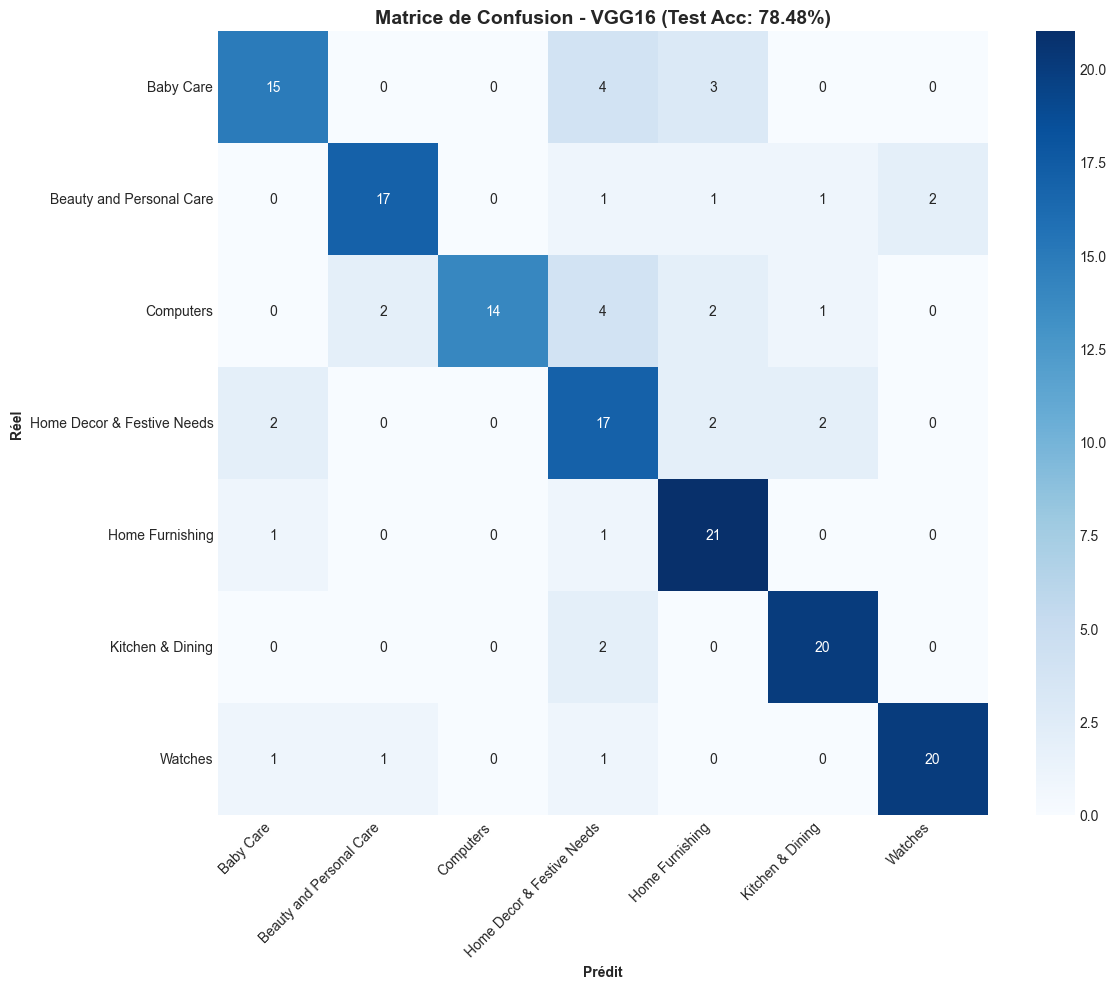

In [11]:
# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel('Prédit', fontweight='bold')
plt.ylabel('Réel', fontweight='bold')
plt.title(f'Matrice de Confusion - {best_model_name} (Test Acc: {test_acc:.2%})',
         fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'confusion_matrix_test.png', dpi=150, bbox_inches='tight')
plt.show()

## 10. COURBES D'APPRENTISSAGE

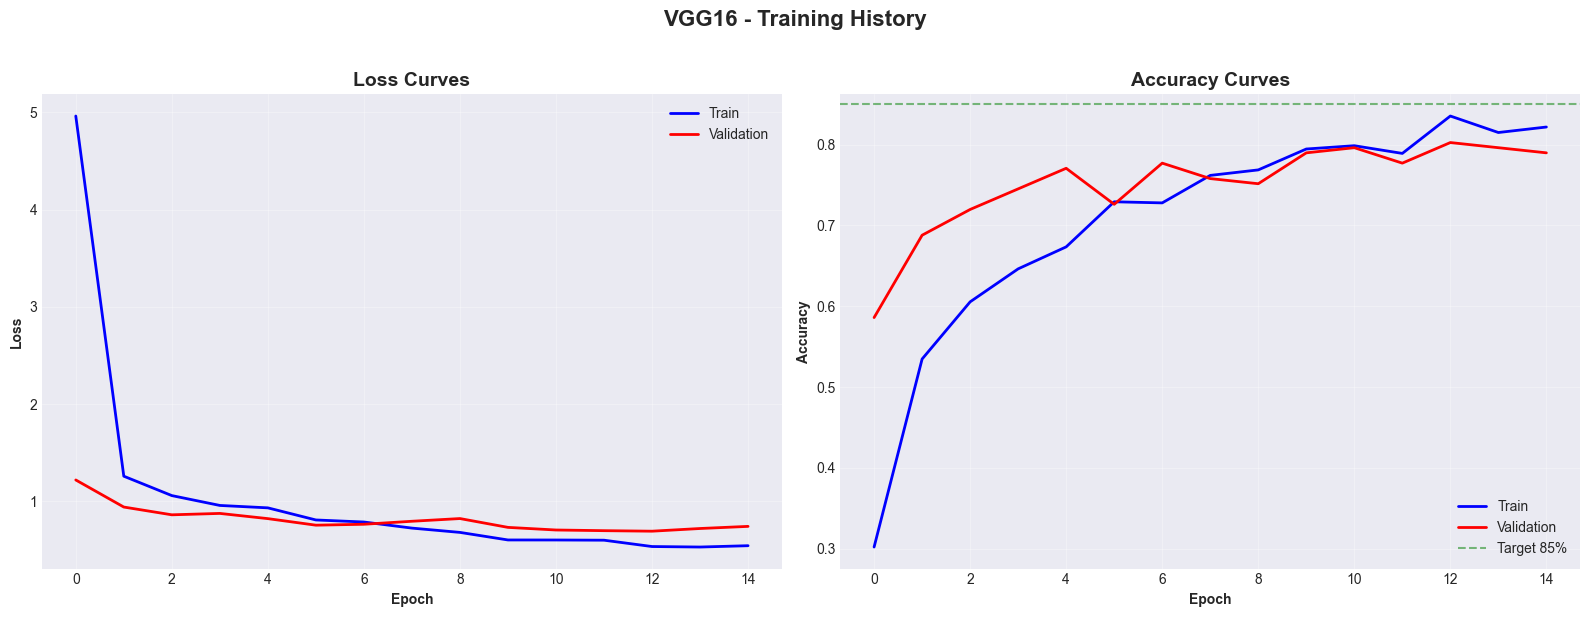

In [12]:
# Sélection de l'historique du meilleur modèle
if best_model_name == 'MobileNetV3-Small':
    history = history_mobile
elif best_model_name == 'EfficientNetB0':
    history = history_eff
else:
    history = history_vgg

# Courbes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Loss
ax1.plot(history.history['loss'], 'b-', label='Train', linewidth=2)
ax1.plot(history.history['val_loss'], 'r-', label='Validation', linewidth=2)
ax1.set_xlabel('Epoch', fontweight='bold')
ax1.set_ylabel('Loss', fontweight='bold')
ax1.set_title('Loss Curves', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Accuracy
ax2.plot(history.history['accuracy'], 'b-', label='Train', linewidth=2)
ax2.plot(history.history['val_accuracy'], 'r-', label='Validation', linewidth=2)
ax2.axhline(0.85, color='green', linestyle='--', alpha=0.5, label='Target 85%')
ax2.set_xlabel('Epoch', fontweight='bold')
ax2.set_ylabel('Accuracy', fontweight='bold')
ax2.set_title('Accuracy Curves', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.suptitle(f'{best_model_name} - Training History', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(RESULTS_DIR / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## 11. SAUVEGARDE POUR API

In [14]:
# Sauvegarde meilleur modèle
best_model.save(MODELS_DIR / 'cnn_final.keras')

# Label encoder
label_encoder = {cat: i for i, cat in enumerate(CATEGORIES)}
joblib.dump(label_encoder, MODELS_DIR / 'label_encoders.pkl')

# Métriques finales
final_metrics = {
    'best_model': best_model_name,
    'test_accuracy': float(test_acc),
    'test_f1_score': float(test_f1),
    'val_accuracy': float(best_val_acc),
    'training_time_minutes': float(results[results['Modèle']==best_model_name].iloc[0]['Temps (min)']),
    'n_parameters': int(best_model.count_params()),
    'all_models_comparison': results.to_dict('records'),
    'categories': CATEGORIES,
    'n_train': len(train_df),
    'n_val': len(val_df),
    'n_test': len(test_df)
}

with open(RESULTS_DIR / 'final_metrics.json', 'w') as f:
    json.dump(final_metrics, f, indent=2)

print("\n" + "="*70)
print("✅ MODÉLISATION TERMINÉE")
print("="*70)
print(f"\n Meilleur modèle: {best_model_name}")
print(f" Test Accuracy: {test_acc*100:.2f}%")
print(f" Temps total: {results['Temps (min)'].sum():.1f} min")
print(f"\n Fichiers sauvegardés:")
print(f"   - {MODELS_DIR}/cnn_final.keras")
print(f"   - {MODELS_DIR}/label_encoders.pkl")
print(f"   - {RESULTS_DIR}/final_metrics.json")
print(f"   - Courbes et matrices (PNG)")

if test_acc >= 0.85:
    print("\n OBJECTIF ATTEINT: Accuracy ≥ 85% !")
else:
    print(f"\n Accuracy {test_acc*100:.1f}% < 85%")


✅ MODÉLISATION TERMINÉE

 Meilleur modèle: VGG16
 Test Accuracy: 78.48%
 Temps total: 138.1 min

 Fichiers sauvegardés:
   - c:\Users\hp\Documents\AS3_2025-2026\SEMESTRE_1\NLP\Projet\Projet_NLP\models/cnn_final.keras
   - c:\Users\hp\Documents\AS3_2025-2026\SEMESTRE_1\NLP\Projet\Projet_NLP\models/label_encoders.pkl
   - c:\Users\hp\Documents\AS3_2025-2026\SEMESTRE_1\NLP\Projet\Projet_NLP\outputs\deep_learning_supervised/final_metrics.json
   - Courbes et matrices (PNG)

 Accuracy 78.5% < 85%
